# Online Selection of HLS Representations

In [1]:
from lrcb.bandits.multirep_finite import FiniteMultiBandit
from lrcb.representations.finite_representations import make_random_rep, hls_rank, rank, derank_hls, make_hls_rank
from lrcb.representations.finite_representations import is_cmb, is_hls, spans, hls_lambda, derank_cmb, LinearRepresentation
from lrcb.algos.oful import oful
from lrcb.algos.lr_oful import select_oful
from lrcb.algos.maximin_oful import maximin_oful
import math
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lrcb.visualization.notebook_utils as nu
from jupyterthemes import jtplot
#jtplot.style()
plt.rcParams['figure.figsize'] = [12, 9]

## Common settings

In [2]:
nc = 100
na = 5
dim = 20
noise = 0.1
seeds = range(10)

Generate original HLS representation

In [3]:
r0 = make_random_rep(nc, na, dim, normalize=True)
assert is_hls(r0)

OFUL settings

In [4]:
iterations = 1000
reg = 0.1
delta = 0.1
param_bound = 1. #Guaranteed by make_random_rep(..., normalize=True)

## CMB, destructive approach (different parameter) (t)

Re-use the same original HLS representation

Generate non-HLS **equivalent** representations with varying HLS rank **and different parameters**

In [5]:
reps = [derank_hls(r0, i, transform=True, normalize=True) for i in range(1, dim)] #Random transformation preserving equivalence
reps.append(r0)

for i, r in enumerate(reps[:-1]):
    assert r == reps[-1] #All representations are equivalent
    assert not np.allclose(r._param, reps[-1]._param) #But with different parameters!
    assert not is_hls(r) #Only the original one is HLS
    assert spans(r) #All representations still span R^d
    print('%d/%d %s %f %f' % (hls_rank(r), rank(r), '(CMB)' if is_cmb(r) else '', r.feat_bound(), r.feat_bound(reduce=np.min)))
print('%d/%d %s %f %f' % (hls_rank(reps[-1]), rank(reps[-1]), '(CMB)' if is_cmb(r) else '', reps[-1].opt_feat_bound(), reps[-1].opt_feat_bound(reduce=np.min)))

#Buldi multi-representation problem
problem = FiniteMultiBandit(nc, na, reps)

1/20 (CMB) 14.601830 0.017032
2/20 (CMB) 14.601830 0.017023
3/20 (CMB) 14.601830 0.017128
4/20 (CMB) 14.601830 0.017132
5/20 (CMB) 14.601830 0.017136
6/20 (CMB) 14.601830 0.017177
7/20 (CMB) 14.601830 0.017178
8/20 (CMB) 14.601830 0.017199
9/20 (CMB) 14.601830 0.017228
10/20 (CMB) 14.601830 0.017227
11/20 (CMB) 14.601830 0.017217
12/20 (CMB) 14.601830 0.017280
13/20 (CMB) 14.601830 0.017206
14/20 (CMB) 14.601830 0.017230
15/20 (CMB) 14.601830 0.017232
16/20 (CMB) 14.601830 0.017267
17/20 (CMB) 14.601830 0.017387
18/20 (CMB) 14.601830 0.017383
19/20 (CMB) 14.601830 0.017303
20/20 (CMB) 14.722453 6.930868


Regret of OFUL with different representations

In [6]:
for i in range(len(reps)):
    problem.select_rep(i)
    name = 'oful_rank%d(t)' % hls_rank(reps[i])
    for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname=name)

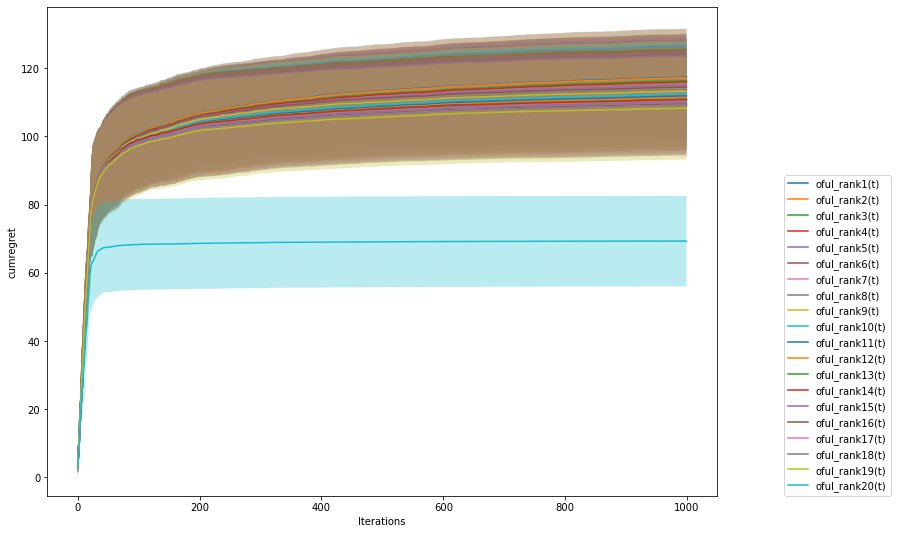

In [7]:
names = ['oful_rank%d(t)' % (i+1) for i in range(dim)]
nu.compare('../logs', names, 'cumregret', seeds)

(Final) cumulated regret is (almost) sorted by hls rank, with the HLS representation having a large advantage

In [8]:
ranking = nu.tournament('../logs', names, 'cumregret', seeds)
ranking

[('oful_rank20(t)', 69.3039657315867),
 ('oful_rank19(t)', 108.26832966826798),
 ('oful_rank18(t)', 109.16486874001694),
 ('oful_rank17(t)', 109.18515419876117),
 ('oful_rank16(t)', 109.46590412933423),
 ('oful_rank15(t)', 110.07926594327992),
 ('oful_rank14(t)', 110.7994651204522),
 ('oful_rank13(t)', 110.94751911479932),
 ('oful_rank12(t)', 111.34215038369685),
 ('oful_rank11(t)', 111.88510186135473),
 ('oful_rank10(t)', 112.47392633937291),
 ('oful_rank9(t)', 113.3023663561944),
 ('oful_rank7(t)', 113.5632707172095),
 ('oful_rank8(t)', 113.70741166072646),
 ('oful_rank6(t)', 114.48977724115885),
 ('oful_rank5(t)', 115.01420364769766),
 ('oful_rank4(t)', 115.98352520932913),
 ('oful_rank3(t)', 116.3478940318236),
 ('oful_rank2(t)', 117.19577487964548),
 ('oful_rank1(t)', 117.35174956780301)]

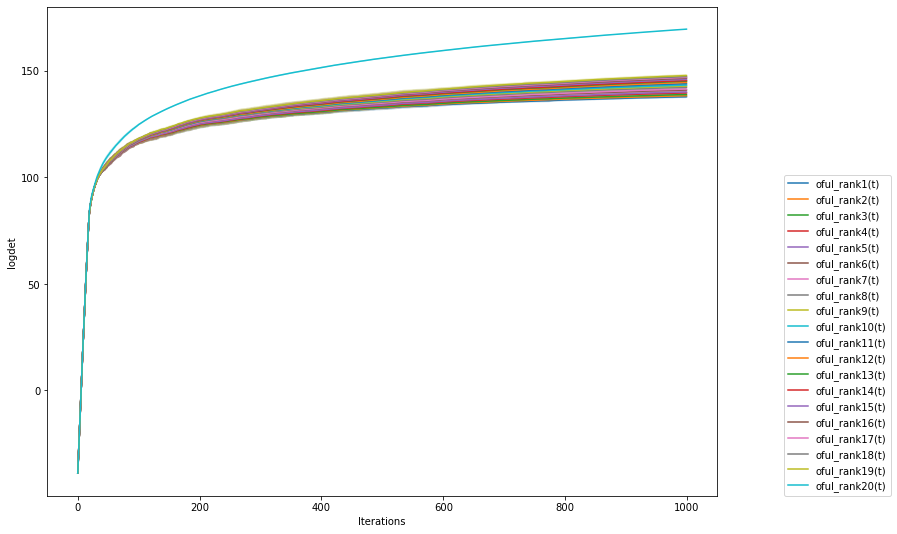

In [9]:
nu.compare('../logs', names, 'logdet', seeds)

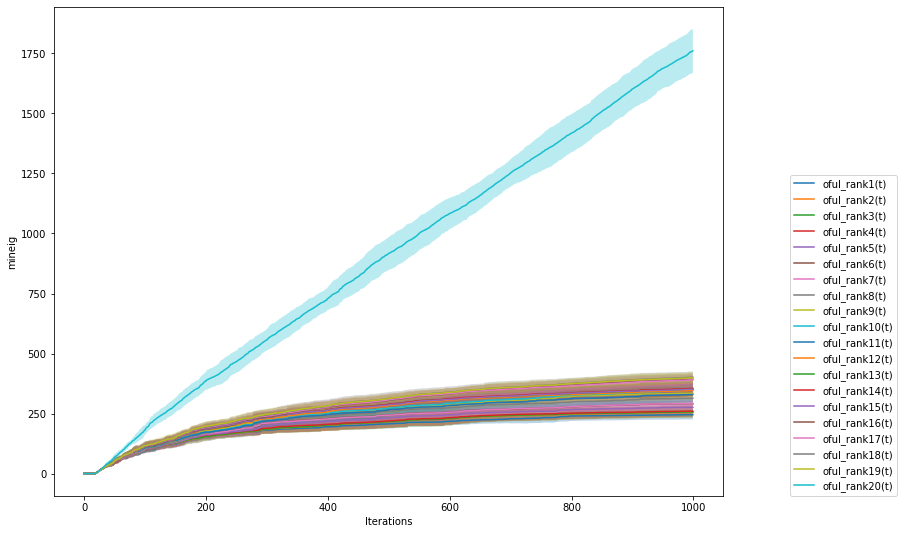

In [10]:
nu.compare('../logs', names, 'mineig', seeds)

Regret of model-selection algorithm compared to best model

In [11]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta/20, param_bound, 
                rule='maxlambdamin',
                seed=seed, verbose=False, logname='oful_select(t)')

In [12]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta/20, param_bound, 
                rule='minbonus',
                seed=seed, verbose=False, logname='oful_meta(t)')

In [13]:
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta/20, param_bound,
                seed=seed, verbose=False, logname='oful_maximin(t)')

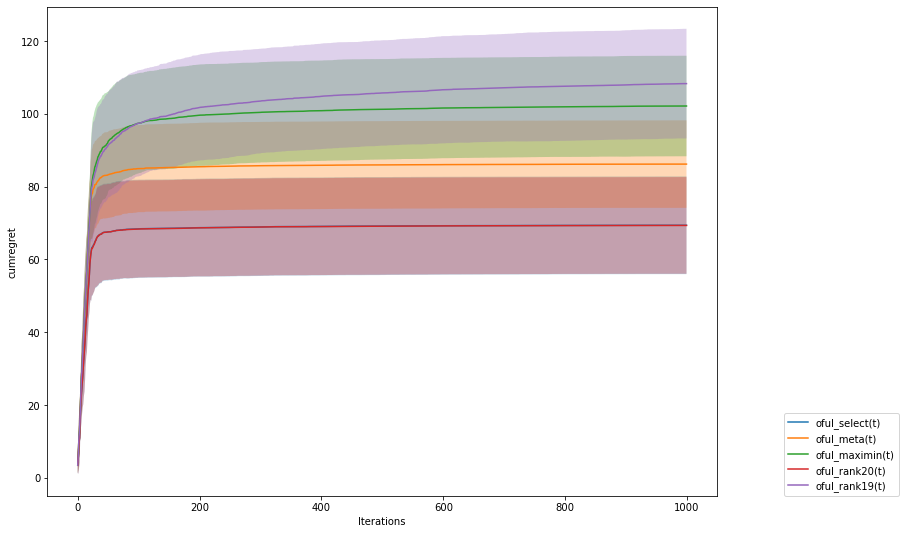

In [14]:
best = ranking[0][0]
nu.compare('../logs', ['oful_select(t)', 'oful_meta(t)', 'oful_maximin(t)', best, ranking[1][0]], 'cumregret', seeds)

Representations selected by model-selection algorithms

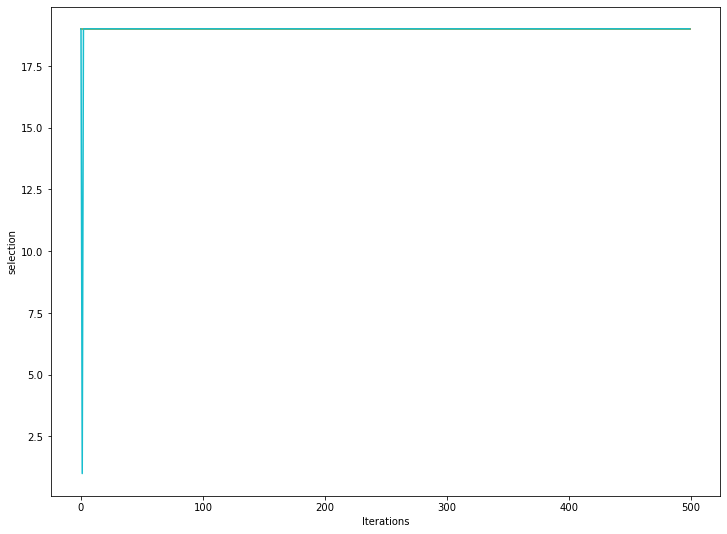

In [15]:
nu.plot_all('../logs', 'oful_select(t)', 'selection', seeds, rows=500)

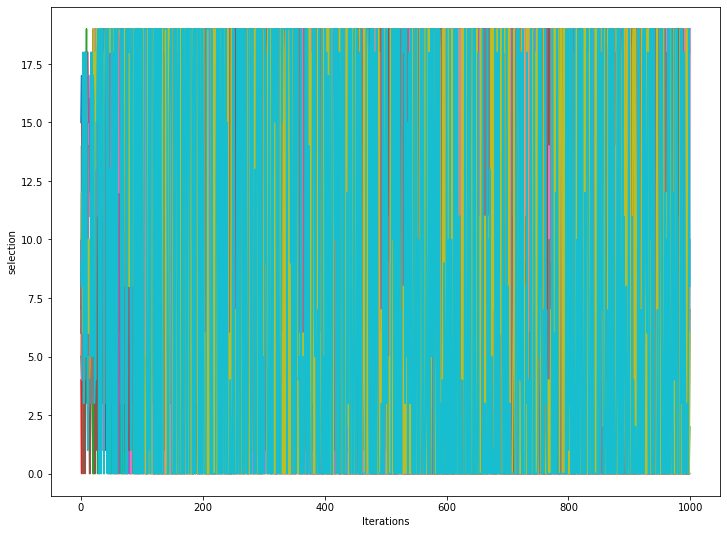

In [16]:
nu.plot_all('../logs', 'oful_meta(t)', 'selection', seeds)

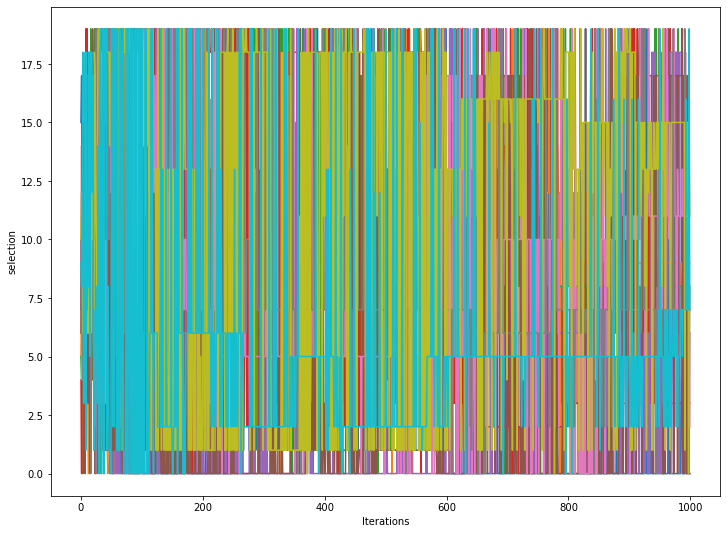

In [17]:
nu.plot_all('../logs', 'oful_maximin(t)', 'selection', seeds)

## CMB, constructive approach (different parameter) (c)

This time I construct a representation of the desired hls rank starting from (the same) reward function

In [18]:
y = r0._rewards()

In [19]:
reps = [make_hls_rank(y, dim=dim, rank=i, transform=True, normalize=True) for i in range(1, dim+1)]

for i, r in enumerate(reps):
    assert np.allclose(r._rewards(), y)  #All representations are equivalent
    assert hls_rank(r) == i+1 #But with different HLS ranks
    assert spans(r) #All representations still span R^d
    print('%d/%d %s %f %f' % (hls_rank(r), rank(r), '(CMB)' if is_cmb(r) else '', r.opt_feat_bound(), r.opt_feat_bound(reduce=np.min)))
    
#Buldi multi-representation problem
problem = FiniteMultiBandit(nc, na, reps)

1/20 (CMB) 8.089375 0.016210
2/20 (CMB) 8.278757 0.016210
3/20 (CMB) 8.580560 0.016210
4/20 (CMB) 8.580560 0.016210
5/20 (CMB) 9.348632 0.016210
6/20 (CMB) 9.348632 0.016210
7/20 (CMB) 9.348632 0.016210
8/20 (CMB) 9.348632 0.016210
9/20 (CMB) 9.348632 0.016210
10/20 (CMB) 9.348632 0.016210
11/20 (CMB) 9.348632 0.016210
12/20 (CMB) 9.348632 0.016210
13/20 (CMB) 9.348632 0.016210
14/20 (CMB) 9.348632 0.016210
15/20 (CMB) 9.348632 0.016210
16/20 (CMB) 9.348632 0.016210
17/20 (CMB) 10.998990 0.016210
18/20 (CMB) 10.998990 0.016210
19/20 (CMB) 10.998990 0.016210
20/20 (CMB) 10.998990 0.016210


Regret of OFUL with different representations

In [20]:
params = []
for i in range(len(reps)):
    problem.select_rep(i)
    name = 'oful_rank%d(c)' % hls_rank(reps[i])
    for seed in seeds:
        params.append(oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname=name))

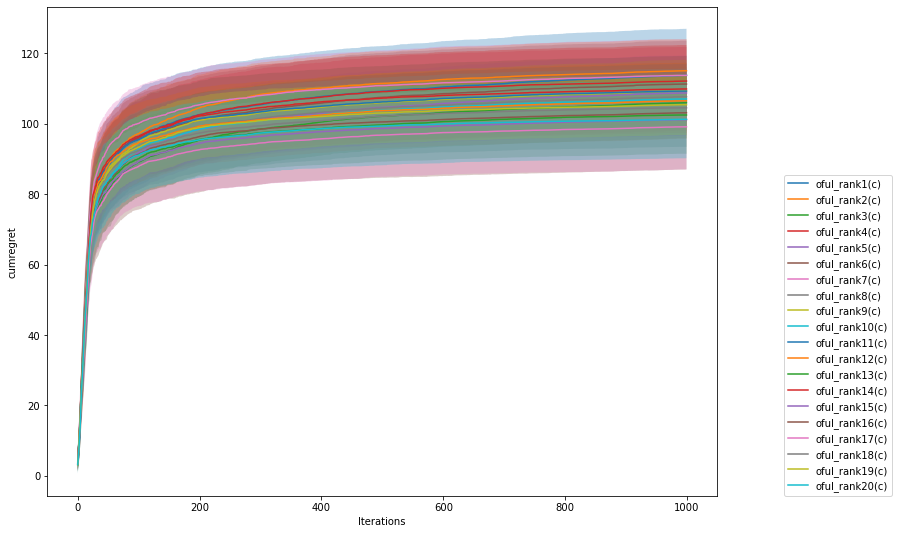

In [21]:
names = ['oful_rank%d(c)' % (i+1) for i in range(dim)] 
nu.compare('../logs', names, 'cumregret', seeds)

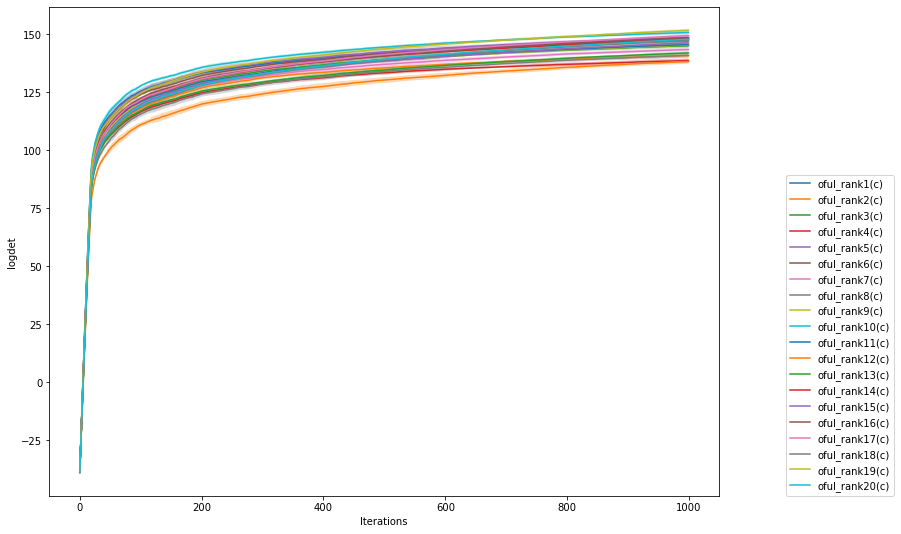

In [22]:
nu.compare('../logs', names, 'logdet', seeds)

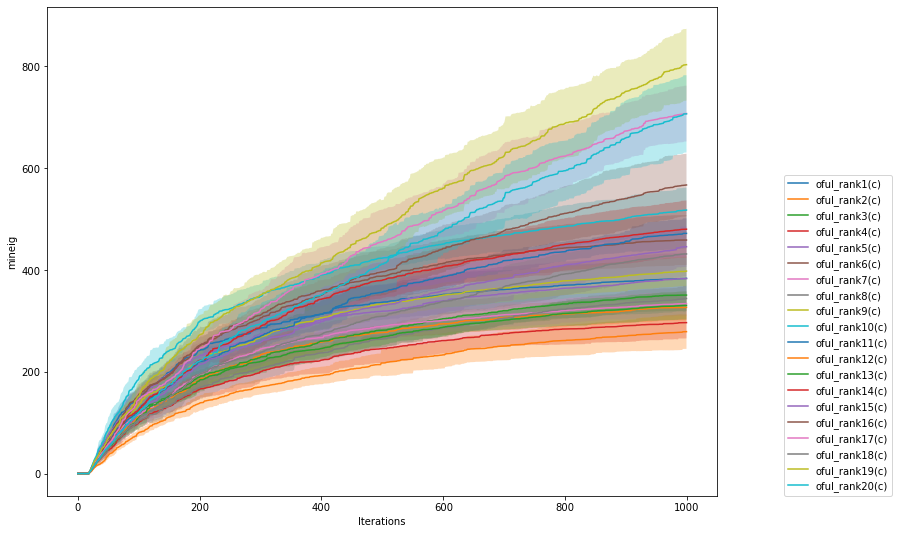

In [23]:
nu.compare('../logs', names, 'mineig', seeds)

(Final) cumulated regret

In [24]:
ranking = nu.tournament('../logs', names, 'cumregret', seeds)
ranking

[('oful_rank17(c)', 99.153352409674),
 ('oful_rank15(c)', 101.17767526499267),
 ('oful_rank20(c)', 101.28382723657974),
 ('oful_rank13(c)', 102.50029080378411),
 ('oful_rank16(c)', 103.15266330679773),
 ('oful_rank18(c)', 104.54611037137931),
 ('oful_rank19(c)', 105.43535297693083),
 ('oful_rank3(c)', 106.01395010089516),
 ('oful_rank12(c)', 106.53254780432113),
 ('oful_rank10(c)', 107.07976800241083),
 ('oful_rank8(c)', 107.69426234891759),
 ('oful_rank5(c)', 108.77212344797331),
 ('oful_rank11(c)', 109.2938168089745),
 ('oful_rank9(c)', 109.37381472794425),
 ('oful_rank14(c)', 109.9010994019352),
 ('oful_rank6(c)', 111.28861135137147),
 ('oful_rank4(c)', 112.14950628877459),
 ('oful_rank1(c)', 113.77817031970896),
 ('oful_rank7(c)', 113.78141256913739),
 ('oful_rank2(c)', 115.07782761553048)]

Regret of model-selection algorithm compared to best model

In [25]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta/20, param_bound, seed=seed, verbose=False, logname='oful_select(c)')

In [26]:
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta/20, param_bound, seed=seed, verbose=False, logname='oful_maximin(c)')

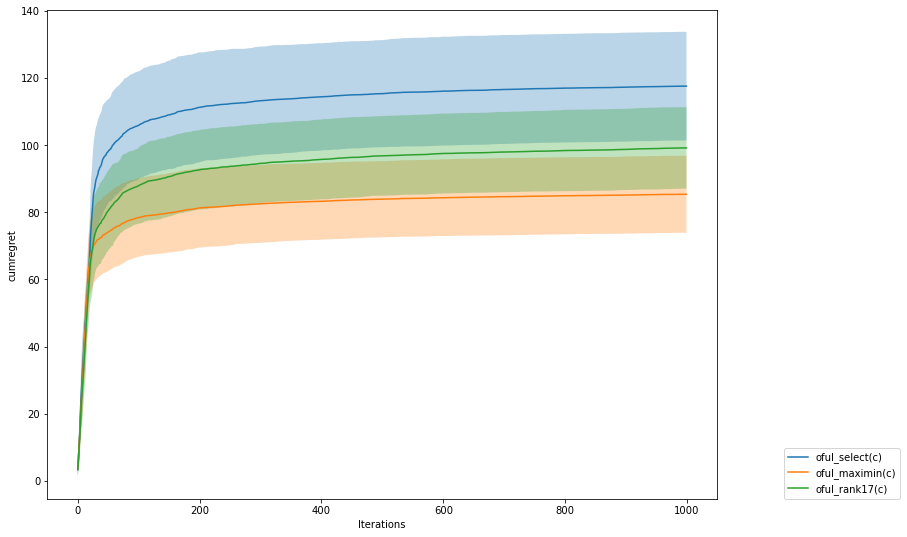

In [27]:
best = ranking[0][0]
nu.compare('../logs', ['oful_select(c)', 'oful_maximin(c)', best], 'cumregret', seeds)

Representations selected by model-selection algorithm

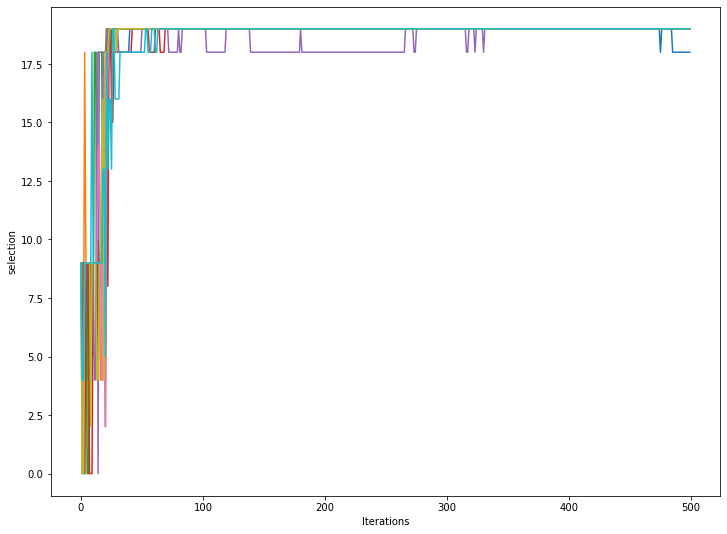

In [28]:
nu.plot_all('../logs', 'oful_select(c)', 'selection', seeds, rows=500)

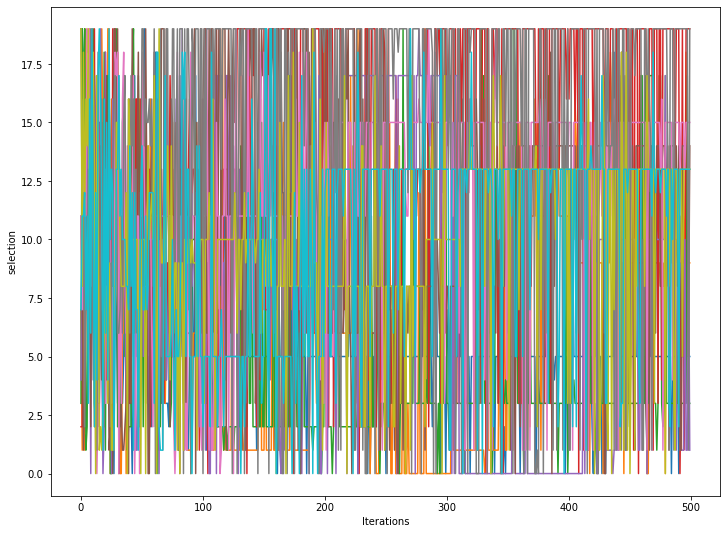

In [29]:
nu.plot_all('../logs', 'oful_maximin(c)', 'selection', seeds, rows=500)

## Why the difference? (different HLS representations)

Original HLS representation

In [30]:
rA = r0

Constructed HLS representation

In [31]:
rB = make_hls_rank(r0._rewards(), dim=dim, rank=dim)

Both are HLS and equivalent

In [32]:
assert rA == rB
assert is_hls(rA)
assert is_hls(rB)

But the performance of OFUL is different

In [33]:
problem = FiniteMultiBandit(nc, na, [rA, rB])

In [34]:
for seed in seeds:
        problem.select_rep(0)
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname='ofulA')
        problem.select_rep(1)
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname='ofulB')

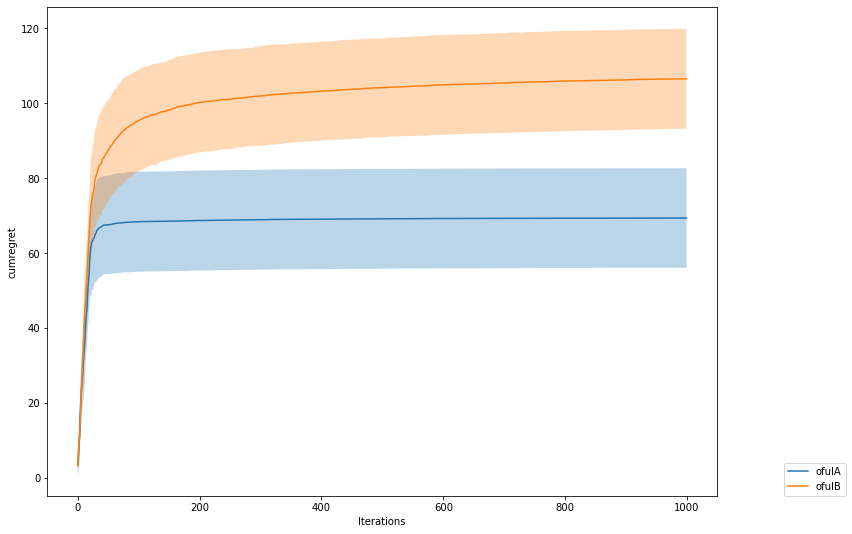

In [35]:
nu.compare('../logs', ['ofulA', 'ofulB'], 'cumregret', seeds)

The reason may be that the minimum eigenvalue of optimal features is different

In [36]:
hls_lambda(rA)

1.6119980085665047

In [37]:
hls_lambda(rB)

0.5600332154423469

In [38]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta/2, param_bound, seed=seed, verbose=False, logname='oful_selectAB')

In [39]:
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta/2, param_bound, seed=seed, verbose=False, logname='oful_maximinAB')

oful_select is able to select the best representation

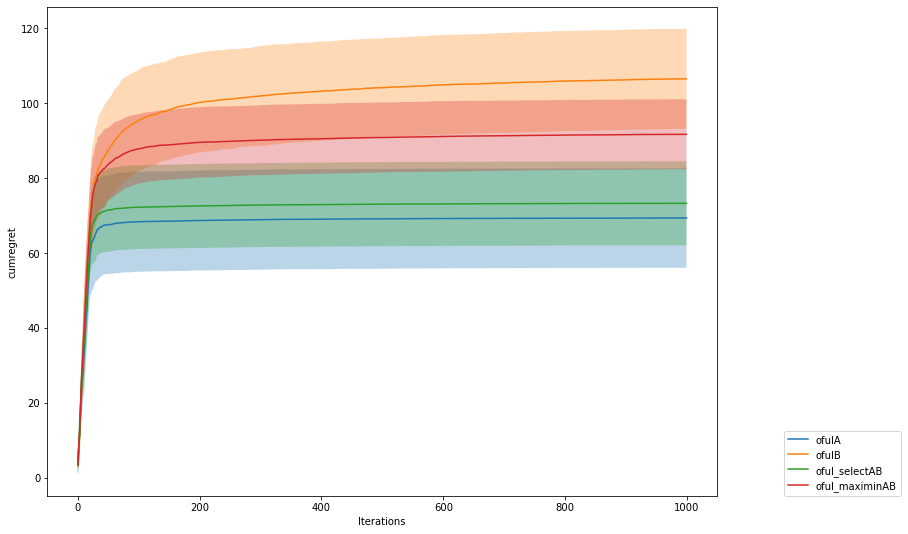

In [40]:
nu.compare('../logs', ['ofulA', 'ofulB', 'oful_selectAB', 'oful_maximinAB'], 'cumregret', seeds)

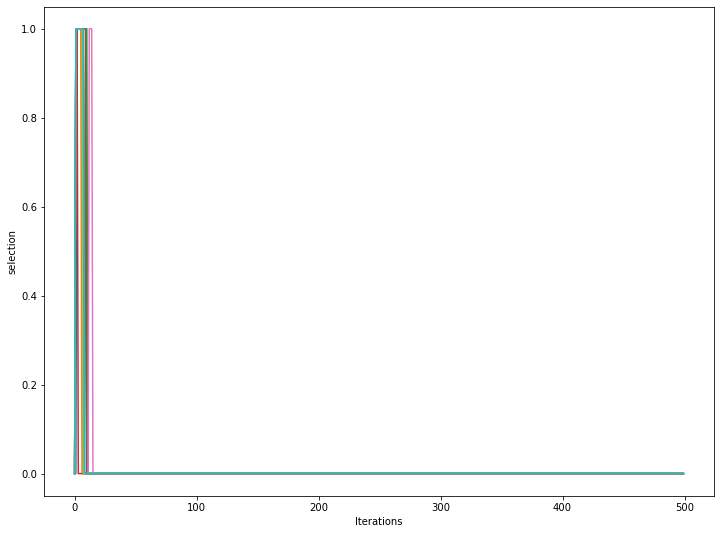

In [41]:
nu.plot_all('../logs', 'oful_selectAB', 'selection', seeds, rows=500)

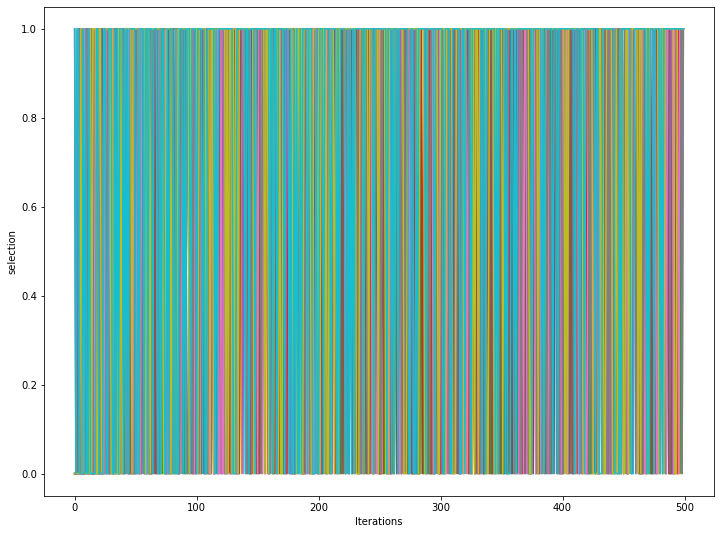

In [42]:
nu.plot_all('../logs', 'oful_maximinAB', 'selection', seeds, rows=500)

## Not CMB (destructive, different param) (n)

I make the original representation NOT CMB while preserving HLS

In [43]:
rr = derank_cmb(r0, save_hls=True)
assert rr == r0
assert is_hls(rr)
assert not is_cmb(rr)

In [44]:
reps = [derank_hls(rr, i, transform=True) for i in range(1, dim)] #Random transformation preserving equivalence
reps.append(rr)

for i, r in enumerate(reps[:-1]):
    assert r == reps[-1] #All representations are equivalent
    assert not np.allclose(r._param, reps[-1]._param) #But with different parameters!
    assert not is_hls(r) #Only the original one is HLS
    assert spans(r) #All representations still span R^d
    assert not is_cmb(r) #None of them is CMB
    print('%d/%d %s %f %f' % (hls_rank(r), rank(r), '(CMB)' if is_cmb(r) else '', r.feat_bound(), r.opt_feat_bound()))
print('%d/%d %s %f %f' % (hls_rank(reps[-1]), rank(reps[-1]), '(CMB)' if is_cmb(r) else '', reps[-1].feat_bound(), reps[-1].opt_feat_bound()))

#Buldi multi-representation problem
problem = FiniteMultiBandit(nc, na, reps)

1/20  14.601830 8.409147
2/20  14.601830 8.403352
3/20  14.601830 10.578724
4/20  14.601830 10.578724
5/20  14.601830 11.631661
6/20  14.601830 11.631661
7/20  14.601830 11.631661
8/20  14.601830 11.631661
9/20  14.601830 11.631661
10/20  14.601830 11.631661
11/20  14.601830 11.631661
12/20  14.601830 11.631661
13/20  14.601830 13.255322
14/20  14.601830 13.255322
15/20  14.601830 13.255322
16/20  14.601830 13.255322
17/20  14.601830 13.255322
18/20  14.601830 13.255322
19/20  14.601830 13.255322
20/20  14.722453 14.722453


Regret of OFUL with different representations

In [45]:
for i in range(len(reps)):
    problem.select_rep(i)
    name = 'oful_rank%d(n)' % hls_rank(reps[i])
    for seed in seeds:
        oful(problem, iterations, reg, noise, delta, param_bound, seed=seed, verbose=False, logname=name)

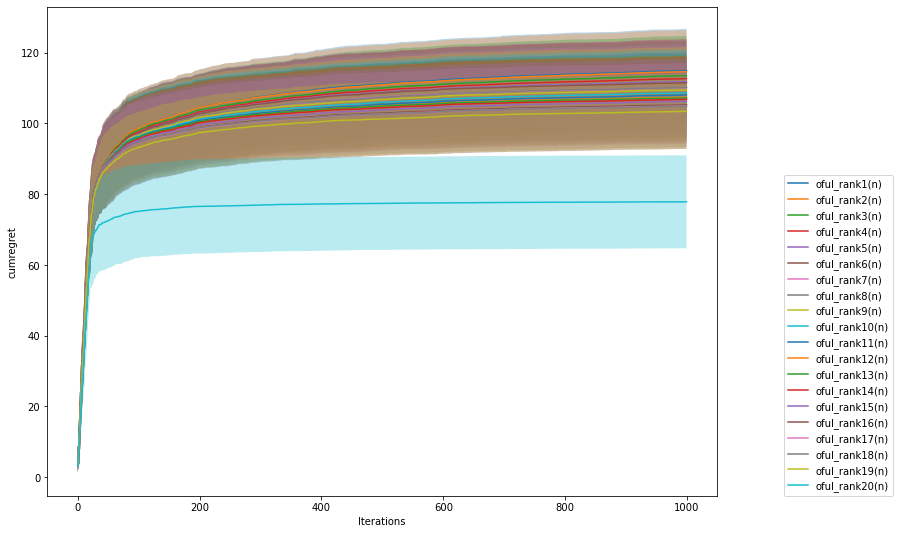

In [46]:
names = ['oful_rank%d(n)' % (i+1) for i in range(dim)]
nu.compare('../logs', names, 'cumregret', seeds)

(Final) cumulated regret is (almost) sorted by hls rank, with the HLS representation having a large advantage

In [47]:
ranking = nu.tournament('../logs', names, 'cumregret', seeds)
ranking

[('oful_rank20(n)', 77.83701645434073),
 ('oful_rank19(n)', 103.4256046908558),
 ('oful_rank18(n)', 104.90145367380546),
 ('oful_rank17(n)', 104.95411941541684),
 ('oful_rank16(n)', 105.28838277251273),
 ('oful_rank15(n)', 106.24390766539548),
 ('oful_rank14(n)', 106.82404548026246),
 ('oful_rank13(n)', 107.24237586285832),
 ('oful_rank12(n)', 107.38910616170453),
 ('oful_rank11(n)', 108.06186286461477),
 ('oful_rank10(n)', 108.67697726677909),
 ('oful_rank9(n)', 109.48433010458803),
 ('oful_rank7(n)', 110.16873208394864),
 ('oful_rank8(n)', 110.18267010898535),
 ('oful_rank6(n)', 111.50956701161427),
 ('oful_rank5(n)', 111.8781000991618),
 ('oful_rank4(n)', 112.69833702459773),
 ('oful_rank3(n)', 113.5355027990388),
 ('oful_rank2(n)', 114.64969600096836),
 ('oful_rank1(n)', 114.95248546356875)]

Regret of model-selection algorithm compared to best model

In [48]:
for seed in seeds:
    select_oful(problem, iterations, reg, noise, delta/20, param_bound, seed=seed, verbose=False, logname='oful_select(n)')

In [49]:
for seed in seeds:
    maximin_oful(problem, iterations, reg, noise, delta/20, param_bound, seed=seed, verbose=False, logname='oful_maximin(n)')

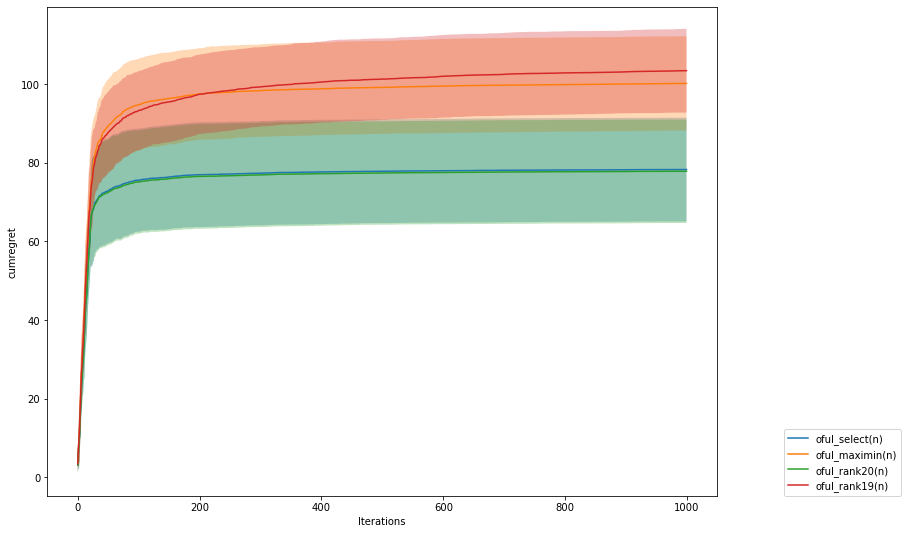

In [50]:
best = ranking[0][0]
nu.compare('../logs', ['oful_select(n)', 'oful_maximin(n)', best, ranking[1][0]], 'cumregret', seeds)

Representations selected by model-selection algorithm

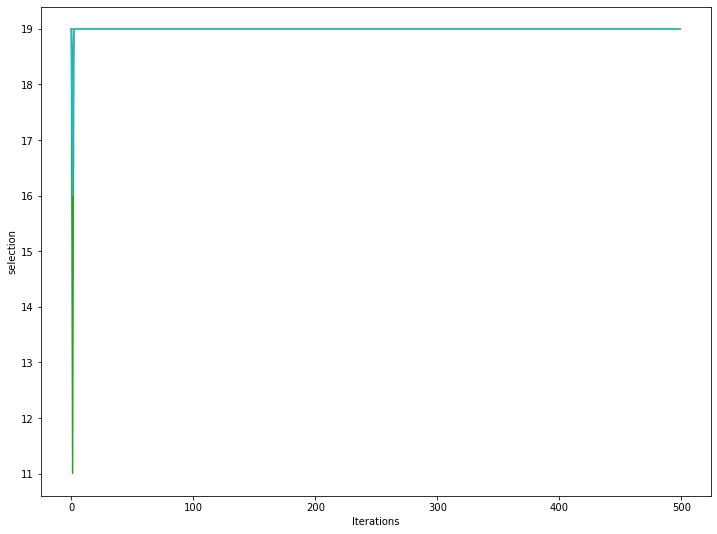

In [51]:
nu.plot_all('../logs', 'oful_select(n)', 'selection', seeds, rows=500)

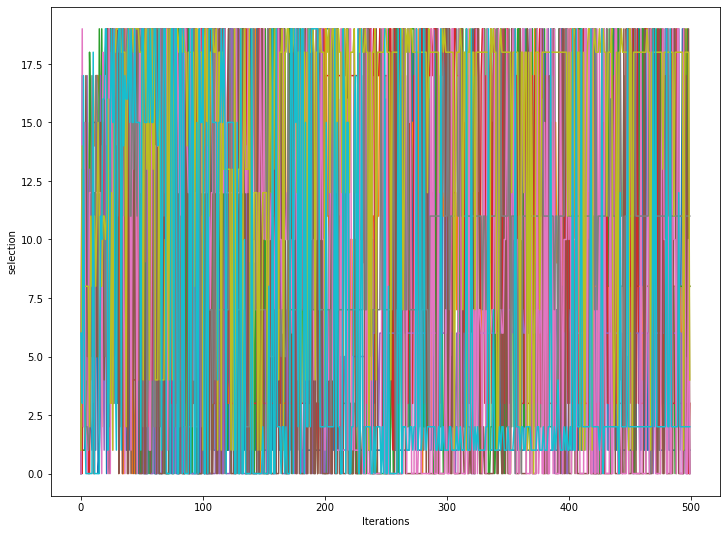

In [52]:
nu.plot_all('../logs', 'oful_maximin(n)', 'selection', seeds, rows=500)